En este notebook lo que vamos a realizar es clustering con los datos sobretodo para eliminar outlayers. Y tambien vamos a ver que variables son las mas importantes de las que nos hemos quedado.

In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [19]:
pd.set_option('display.max_colwidth', None)

In [20]:
df = pd.read_csv("../data/working_data/idealista_data_cleaned_2.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6142 entries, 0 to 6141
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   propertyCode     6142 non-null   int64  
 1   price            6142 non-null   int64  
 2   priceInfo        6142 non-null   object 
 3   propertyType     6142 non-null   object 
 4   operation        6142 non-null   object 
 5   size             6142 non-null   float64
 6   rooms            6142 non-null   float64
 7   bathrooms        6142 non-null   float64
 8   province         6142 non-null   object 
 9   municipality     6142 non-null   object 
 10  district         6142 non-null   object 
 11  country          6142 non-null   object 
 12  neighborhood     6142 non-null   object 
 13  latitude         6142 non-null   float64
 14  longitude        6142 non-null   float64
 15  status           6142 non-null   object 
 16  newDevelopment   6142 non-null   bool   
 17  priceByArea   

Lo primero que vamos a hacer es pasar los datos a valores numéricos para poder hacerle el análisis de las componentes principales.

In [21]:
df["floor"].unique()

array([nan, '8', '1', '3', '7', '2', '4', 'bj', '26', '6', '9', '5', '10',
       '18', '17', '16', '20', '14', '13', '23', 'en', '24', '11', '28',
       '12', '19', '27', '15', '25', '22', 'ss', '-1', 'st', '-2', 'ati'],
      dtype=object)

In [22]:
# Mapea valores textuales a enteros según significado
mapeo = {
    "bj": 0,     # Bajo
    "en": 1.5,   # Entreplanta
    "ati": 50,  # Ático, lo voy a representar con 50 refiriendo a que siempre es lo mas alto.
    "st": -1,   # sotano
    "ss": 0.5     # sobre suelo
}

# Aplica mapeo
df["floor"] = df["floor"].replace(mapeo)
df["floor"] = df["floor"].fillna(0)

# Convierte el resto a numérico (valores que eran strings de números)
df["floor"] = pd.to_numeric(df["floor"], errors="coerce")

In [23]:
def categorical_to_numeric(df, column):
    """
    Convierte una columna categórica a numérica.
    """
    if df[column].dtype == "object":
        # Crea un mapeo de categorías a números
        unique_values = df[column].unique()
        mapping = {value: i for i, value in enumerate(unique_values)}
        return df[column].map(mapping)
    if df[column].dtype == "bool": 
        return df[column].astype(int)
    else:
        return df[column]

In [24]:
for column in df.columns:
    df[column] = categorical_to_numeric(df, column)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6142 entries, 0 to 6141
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   propertyCode     6142 non-null   int64  
 1   price            6142 non-null   int64  
 2   priceInfo        6142 non-null   int64  
 3   propertyType     6142 non-null   int64  
 4   operation        6142 non-null   int64  
 5   size             6142 non-null   float64
 6   rooms            6142 non-null   float64
 7   bathrooms        6142 non-null   float64
 8   province         6142 non-null   int64  
 9   municipality     6142 non-null   int64  
 10  district         6142 non-null   int64  
 11  country          6142 non-null   int64  
 12  neighborhood     6142 non-null   int64  
 13  latitude         6142 non-null   float64
 14  longitude        6142 non-null   float64
 15  status           6142 non-null   int64  
 16  newDevelopment   6142 non-null   int64  
 17  priceByArea   

In [26]:
df

,propertyCode,price,priceInfo,propertyType,operation,size,rooms,bathrooms,province,municipality,...,country,neighborhood,latitude,longitude,status,newDevelopment,priceByArea,floor,hasLift,hasParkingSpace
0,107634575,985000,0,0,0,245.0,4.0,3.0,0,0,...,0,0,36.726046,-4.392859,0,0,4020.0,0.0,0.0,1
1,106393537,265000,0,1,0,66.0,2.0,1.0,0,0,...,0,1,36.703176,-4.438555,0,0,4015.0,8.0,1.0,0
2,106281335,275000,0,1,0,82.0,2.0,2.0,0,0,...,0,2,36.731530,-4.414621,0,0,3354.0,1.0,1.0,0
3,107840913,1600000,0,1,0,174.0,3.0,2.0,0,0,...,0,3,36.721393,-4.405125,0,0,9195.0,1.0,1.0,1
4,97484253,550000,0,1,0,143.0,3.0,2.0,0,0,...,0,4,36.720695,-4.421476,0,0,3846.0,3.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6137,103725086,9000,0,8,0,0.0,0.0,0.0,0,6,...,0,109,36.508218,-4.725346,3,0,300.0,-1.0,1.0,0
6138,108599387,22000,0,8,0,0.0,0.0,0.0,0,3,...,0,80,36.590990,-4.535055,3,0,815.0,0.0,0.0,0
6139,103380778,8000,0,8,0,0.0,0.0,0.0,0,14,...,0,140,36.631383,-4.502652,3,0,276.0,-1.0,0.0,0
6140,103724424,9900,0,8,0,0.0,0.0,0.0,0,3,...,0,94,36.581868,-4.551639,3,0,381.0,-1.0,1.0,0


Ya tenemos los datos numerico por lo que ya le podemos realizar el analisis de las componentes principales para ver cuantas variables son las que tienen mayor importancia para nuestro modelo

In [27]:
# Definimos las caractirísticas y el target que vamos a utilizar para el análisis de componentes principales
X = df
X = X.drop(columns="price")
#También tengo que eliminar la columna de propertyCode para el PCA ya que es una columna identificativa
X = X.drop(columns="propertyCode")
Y = df["price"]

In [28]:
# vamos a escalar los datos primero
from sklearn.preprocessing import StandardScaler
standardized = StandardScaler()
standardized.fit(X)
scaled_data = standardized.transform(X)
X = scaled_data
X.shape

(6142, 19)

In [29]:
pca = PCA(n_components = 19)                          # Define a PCA object.
pca.fit(X)   

PCA(n_components=19)

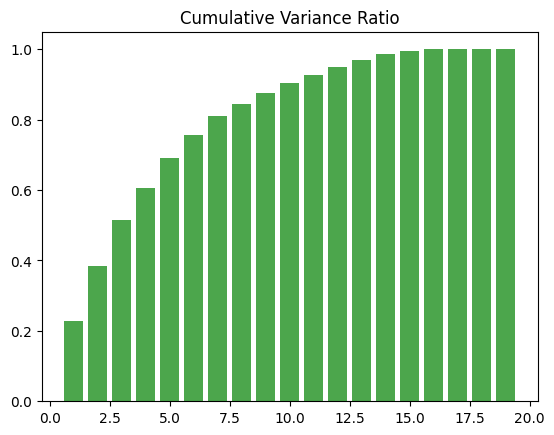

In [30]:
# Visualize the CVRs as a Barplot.
CVRs = np.cumsum(pca.explained_variance_ratio_)        # Calculate the CVRs.
nPCs = np.arange(19)+1                                 # Define an array that corresponds to the number of PCs.
plt.bar(nPCs,CVRs,color = 'green', alpha=0.7)  
plt.title('Cumulative Variance Ratio')
plt.show()

Con unas 15 o 16 variables seria suficiente, lo que tiene sentido, porque no creo que aporten demasiado a lo que es el modelo las características: province, municipality, district, country o neighborhood

Quiero usar dbscan para detectar los outliers, voy a hacer dos pruebas, 
La primera voy a usar solo price y propertytipe para ver como se comportan los datos graficamente y si hay precios que se salen mucho de la media por el tipo de vivienda
En la segunda voy a añadir bastantes columnas y voy a ponerlo creo que solo en forma de codigo, con el codigo de abajo, obviamente no voy a poner en esas columnas las de los barrios creo, voy a poner mas bien las otras

In [45]:
X_1 = df[["price", "propertyType"]]

standardized.fit(X_1)
scaled_data = standardized.transform(X_1)
X_1 = scaled_data

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_1)

df["dbscan1_labels"] = labels

df_outliers = df[df['dbscan1_labels'] == -1]
print(f"Outliers detectados: {len(df_outliers)}")


Outliers detectados: 12


In [53]:
df["dbscan1_labels"].value_counts()

dbscan1_labels
 0    6101
 2      13
-1      12
 3       6
 1       5
 4       5
Name: count, dtype: int64

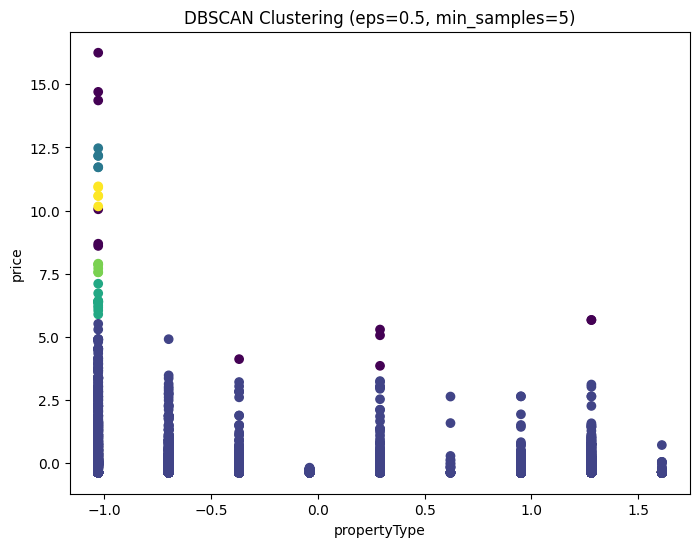

In [46]:
# Plot the clusters
plt.figure(figsize=(8,6))
plt.scatter(X_1[:, 1], X_1[:, 0], c=labels)
plt.xlabel('propertyType')
plt.ylabel('price')
plt.title(f'DBSCAN Clustering (eps={dbscan.eps}, min_samples={dbscan.min_samples})')
plt.show()

In [51]:
X_2 = df.drop(columns=["country", "province", "municipality", "district", "neighborhood", "propertyCode"])

standardized.fit(X_2)
scaled_data = standardized.transform(X_2)
X_2 = scaled_data

dbscan = DBSCAN(eps=1, min_samples=8)
labels = dbscan.fit_predict(X_2)

# Agrega etiquetas al DF original
df['dbscan2_label'] = labels

df_outliers = df[df['dbscan2_label'] == -1]

print(f"Outliers detectados: {len(df_outliers)}")


Outliers detectados: 1100


No puedo quitarme tantiiisimos datos, no se como mirar de mejor forma los outliers o si dejarlo todo y ya esta, pero algo de valor le tengo que sacar a hacer la limpieza la verdad.